In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')


In [45]:
base_dir = './data'
train_path = os.path.join(base_dir, 'train.csv')
test_path = os.path.join(base_dir, 'test.csv')
sub_path = os.path.join(base_dir, 'submission.csv')

In [138]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
submission = pd.read_csv(sub_path)

In [ ]:
## 결측치 처리

In [109]:
print('train 결측치 :')
print(train_data.isna().sum())
print('')
print('test 결측치 :')
print(test_data.isna().sum())

train 결측치 :
id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

test 결측치 :
id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64


In [48]:
def train_delete_missing_mean(col):
    
    col_mean_0= train_data.groupby('hour_bef_precipitation')[col].mean()[0]
    col_mean_1= train_data.groupby('hour_bef_precipitation')[col].mean()[1]
    
    # 처리
    train_data.loc[train_data[col].isnull() & (train_data['hour_bef_precipitation']==0), col] = col_mean_0
    train_data.loc[train_data[col].isnull() & (train_data['hour_bef_precipitation']==1), col] = col_mean_1
    
def test_delete_missing_mean(col):
    
    col_mean_0= train_data.groupby('hour_bef_precipitation')[col].mean()[0]
    col_mean_1= train_data.groupby('hour_bef_precipitation')[col].mean()[1]
    
    # 처리
    test_data.loc[test_data[col].isnull() & (test_data['hour_bef_precipitation']==0), col] = col_mean_0
    test_data.loc[test_data[col].isnull() & (test_data['hour_bef_precipitation']==1), col] = col_mean_1

In [49]:
def train_delete_missing_median(col):
    
    col_median_0= train_data.groupby('hour_bef_precipitation')[col].median()[0]
    col_median_1= train_data.groupby('hour_bef_precipitation')[col].median()[1]
    
    # 처리
    train_data.loc[train_data[col].isnull() & (train_data['hour_bef_precipitation']==0), col] = col_median_0
    train_data.loc[train_data[col].isnull() & (train_data['hour_bef_precipitation']==1), col] = col_median_1
    
def test_delete_missing_median(col):
    
    col_median_0= train_data.groupby('hour_bef_precipitation')[col].median()[0]
    col_median_1= train_data.groupby('hour_bef_precipitation')[col].median()[1]
    
    # 처리
    test_data.loc[test_data[col].isnull() & (test_data['hour_bef_precipitation']==0), col] = col_median_0
    test_data.loc[test_data[col].isnull() & (test_data['hour_bef_precipitation']==1), col] = col_median_1

In [139]:
train_data = train_data.loc[~train_data['hour_bef_temperature'].isna()]
test_data['hour_bef_precipitation'].fillna(0, inplace=True) # 습도가 비안올때의 평균이랑 가깝기 때문에 0으로 채움

for col in test_data.columns:
    train_delete_missing_median(col)
    test_delete_missing_median(col)

In [20]:
## SCALER 추가
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

x_train, y_train = train_data.iloc[:,:-1], train_data['count']
param_grid = {'lgbmregressor__n_estimators':[30, 40, 45, 50, 55, 60],
              'lgbmregressor__boosting_type':['dart', 'gbdt','goss']}
pipe = make_pipeline(StandardScaler(),LGBMRegressor())
grid = GridSearchCV(pipe, scoring='neg_root_mean_squared_error', verbose=1, cv=5, param_grid=param_grid)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    2.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lgbmregressor', LGBMRegressor())]),
             param_grid={'lgbmregressor__boosting_type': ['dart', 'gbdt',
                                                          'goss'],
                         'lgbmregressor__n_estimators': [30, 40, 45, 50, 55,
                                                         60]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [21]:
print(grid.best_params_)
print(-grid.best_score_)

{'lgbmregressor__boosting_type': 'gbdt', 'lgbmregressor__n_estimators': 40}
38.828352824928245


In [23]:
grid_lgbm_res = grid.best_estimator_.predict(test_data)
submission['count'] = grid_lgbm_res
submission.to_csv('./new_lgbm1.csv', index=False)

In [ ]:
## minmax scaler

In [30]:
## SCALER 추가
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

x_train, y_train = train_data.iloc[:,:-1], train_data['count']
param_grid = {'lgbmregressor__n_estimators':[30, 40, 45, 50, 55, 59, 60,61, 65, 67],
              'lgbmregressor__boosting_type':['dart', 'gbdt','goss']}
pipe = make_pipeline(MinMaxScaler(),LGBMRegressor())
grid = GridSearchCV(pipe, scoring='neg_root_mean_squared_error', verbose=1, cv=5, param_grid=param_grid)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    4.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('lgbmregressor', LGBMRegressor())]),
             param_grid={'lgbmregressor__boosting_type': ['dart', 'gbdt',
                                                          'goss'],
                         'lgbmregressor__n_estimators': [30, 40, 45, 50, 55, 59,
                                                         60, 61, 65, 67]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [31]:
print(grid.best_params_)
print(-grid.best_score_)

{'lgbmregressor__boosting_type': 'gbdt', 'lgbmregressor__n_estimators': 60}
38.73793644667893


In [29]:
grid_lgbm_res = grid.best_estimator_.predict(test_data)
submission['count'] = grid_lgbm_res
submission.to_csv('./new_lgbm2.csv', index=False)

------------------------

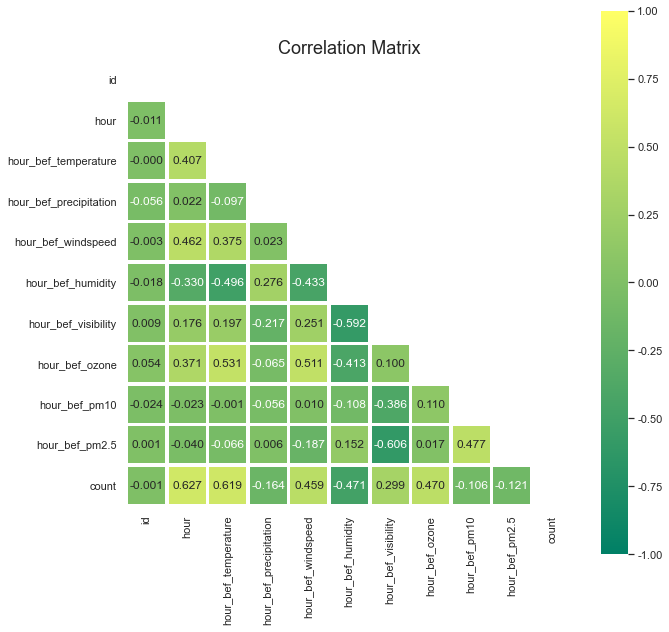

In [55]:
corr = train_data.corr() # 상관계수 계산

plt.figure(figsize=(10,10))
sns.set(style='white')  # 배경 흰색으로 변경
mask = np.triu(np.ones_like(corr, dtype=bool)) # 하삼각행렬 마스크 
sns.heatmap(corr, mask=mask, cmap='summer', vmin=-1, vmax=1, center=0,
            square=True, linewidths=2.5, annot=True, fmt='.3f')
plt.title('Correlation Matrix', fontsize=18)
plt.show()

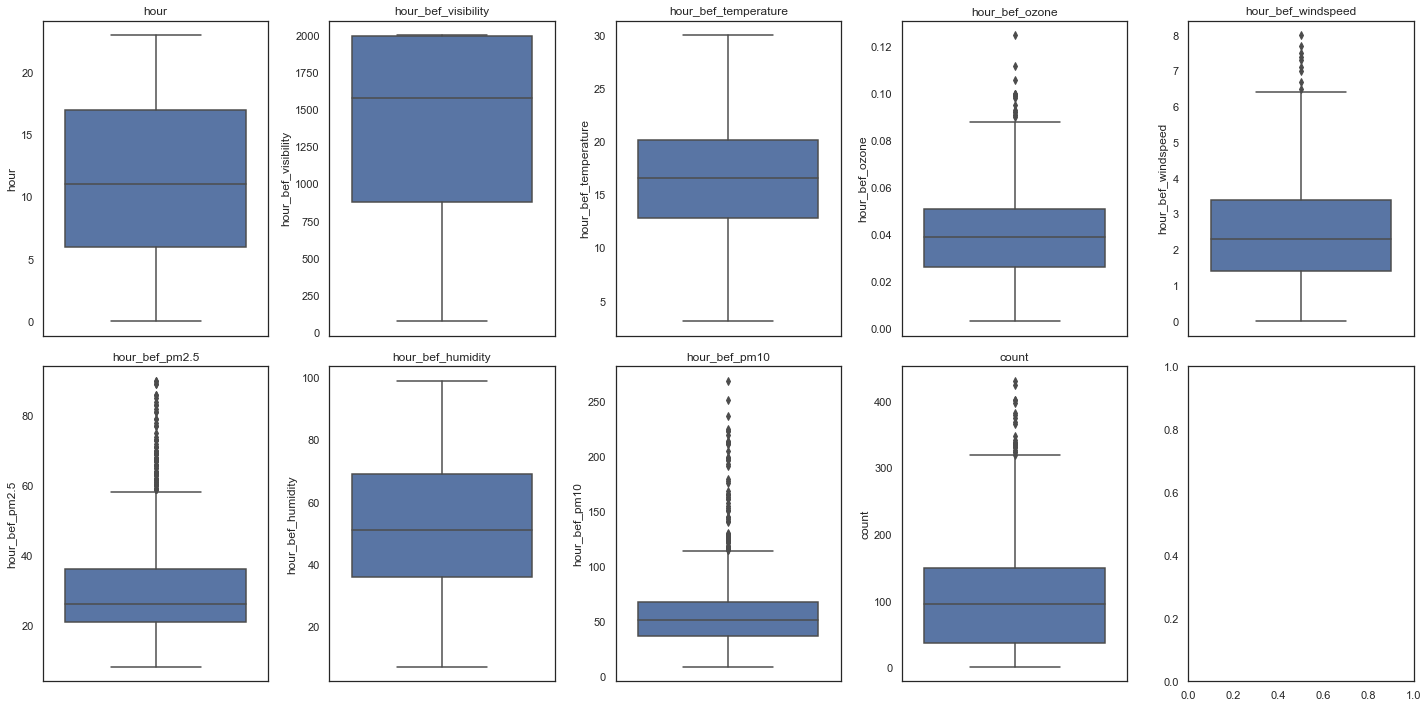

In [104]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for col, axis in zip(set(train_data.columns)-set(['id', 'hour_bef_precipitation']), ax.ravel()):
    sns.boxplot(data=train_data, y=col, ax=axis)
    axis.set_title(col)
fig.tight_layout()
plt.show()

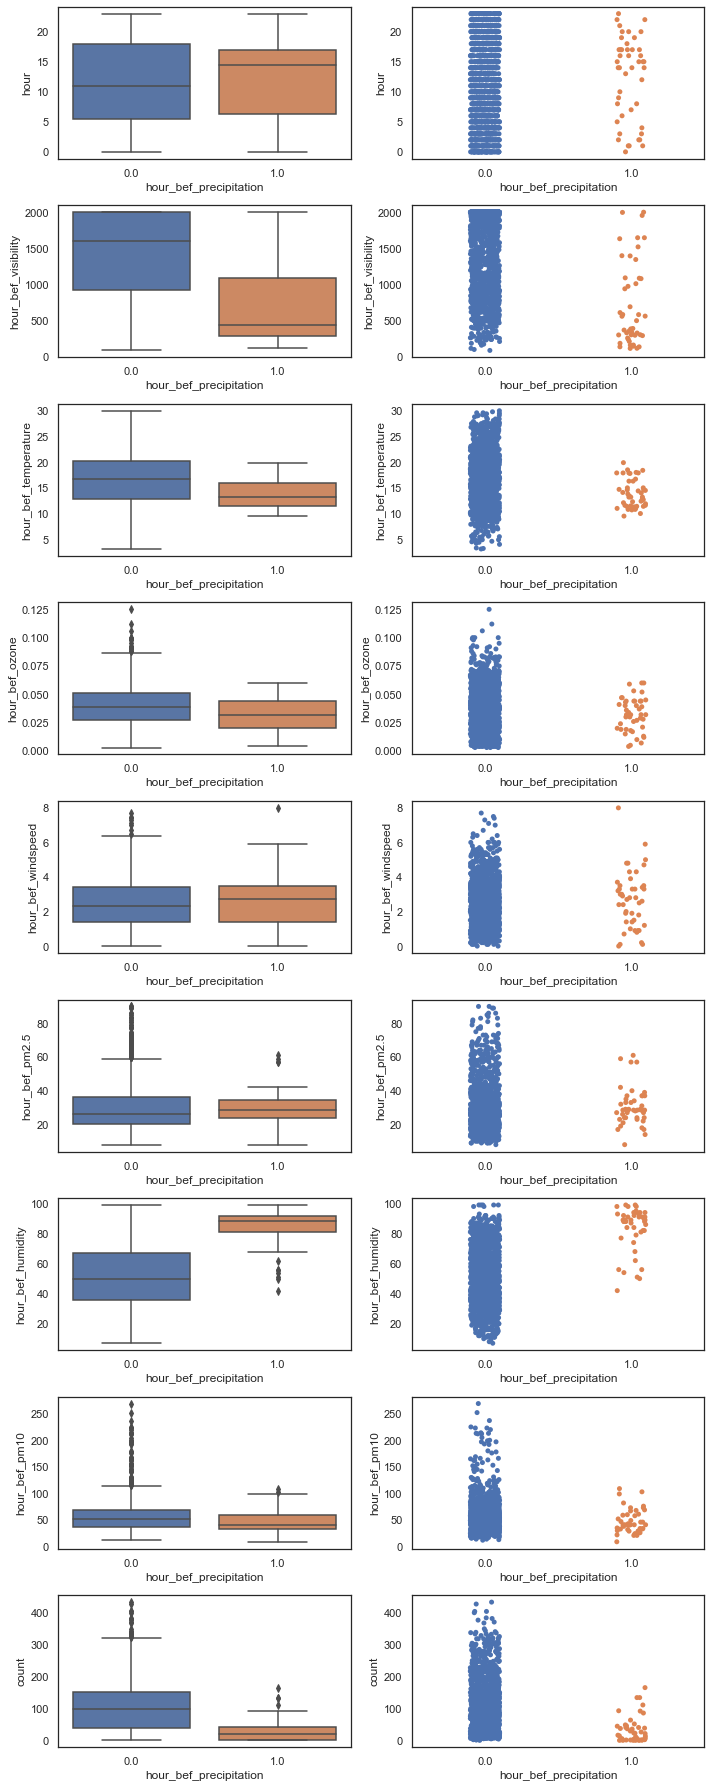

In [105]:
fig, ax = plt.subplots(9, 2, figsize=(10, 25))
for col, ax in zip(set(train_data.columns)-set(['id', 'hour_bef_precipitation']), ax):
    ax1, ax2 = ax
    sns.boxplot(data=train_data, y=col, x='hour_bef_precipitation', ax=ax1)
    sns.stripplot(data=train_data, y=col, x='hour_bef_precipitation', ax=ax2)
    axis.set_title(col)
fig.tight_layout()
plt.show()

In [61]:
train_data.columns

Index(['id', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'hour_bef_pm10', 'hour_bef_pm2.5', 'count'],
      dtype='object')

In [106]:
from scipy import stats

def delete_outlier(col):
    global train_data
    zscore_threshold = 1.96
    
    outliers = np.abs(stats.zscore(train_data[col]))> zscore_threshold
    train_data = train_data[~outliers]
    print(outliers.sum())
    return train_data

In [133]:
for col in ['count']:
    train_data = delete_outlier(col)

79


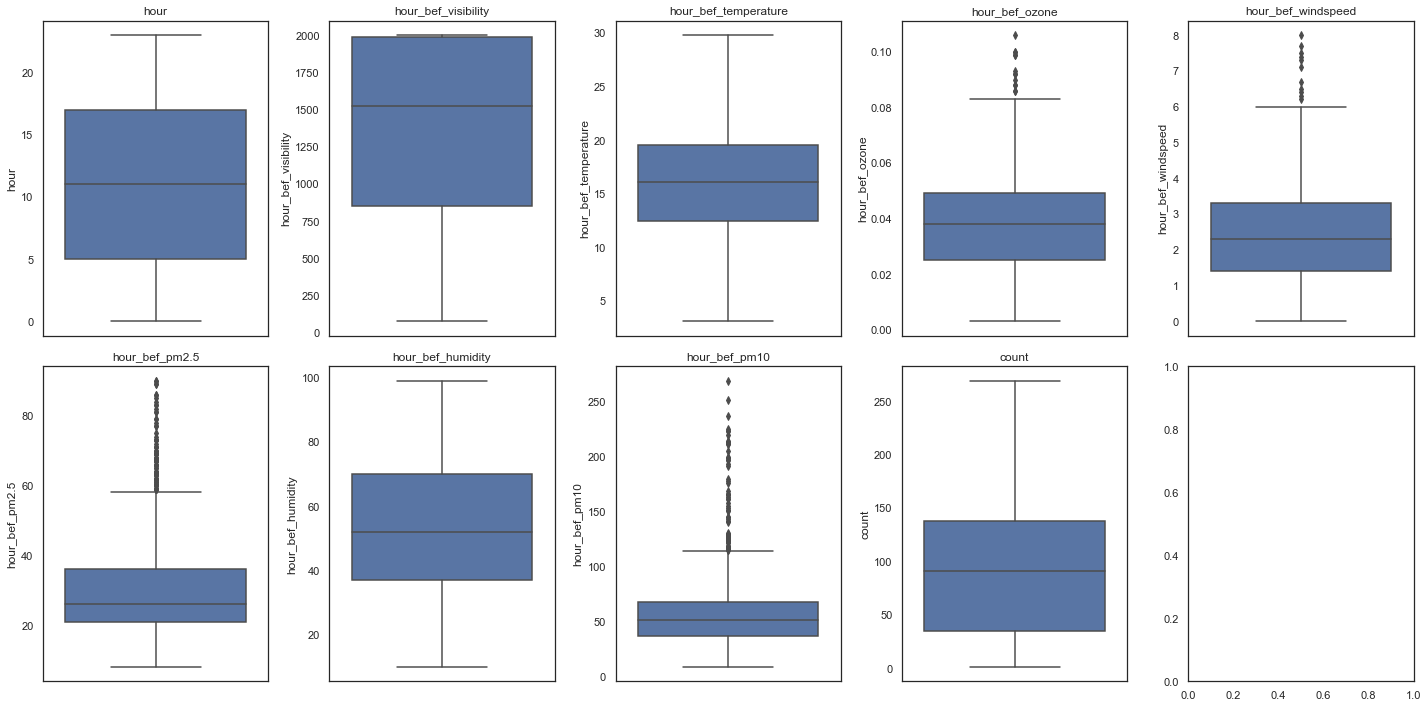

In [137]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for col, axis in zip(set(train_data.columns)-set(['id', 'hour_bef_precipitation']), ax.ravel()):
    sns.boxplot(data=train_data, y=col, ax=axis)
    axis.set_title(col)
fig.tight_layout()
plt.show()

In [134]:
## ['hour_bef_windspeed', 'hour_bef_ozone'] 제거
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

x_train, y_train = train_data.iloc[:,:-1], train_data['count']
param_grid = {'lgbmregressor__n_estimators':[30, 40, 45, 50, 55, 59, 60,61, 65, 67],
              'lgbmregressor__boosting_type':['dart', 'gbdt','goss']}
pipe = make_pipeline(MinMaxScaler(),LGBMRegressor())
grid = GridSearchCV(pipe, scoring='neg_root_mean_squared_error', verbose=1, cv=5, param_grid=param_grid)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    4.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('lgbmregressor', LGBMRegressor())]),
             param_grid={'lgbmregressor__boosting_type': ['dart', 'gbdt',
                                                          'goss'],
                         'lgbmregressor__n_estimators': [30, 40, 45, 50, 55, 59,
                                                         60, 61, 65, 67]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [135]:
print(grid.best_params_)
print(-grid.best_score_)

{'lgbmregressor__boosting_type': 'gbdt', 'lgbmregressor__n_estimators': 65}
33.64715306622222


In [136]:
grid_lgbm_res = grid.best_estimator_.predict(test_data)
submission['count'] = grid_lgbm_res
submission.to_csv('./outlier_lgbm1.csv', index=False)

------------------------------

- 지금까지 정리
    - 모델 : lgbm이 제일 성능이 좋다.
    - 전처리 : minmaxscaler가 미세하게 standardscaler 보다는 좋아보인다.
    - 결측치 처리는 iterative, 중간값, 평균값을 시도해봤다. 중간값과 iterative 모두 비슷하다.
    - outlier : drop으로 없애봤는데, 의미 없어보인다.
        - 그러면 다른값으로 교체는??
    

In [142]:
from lightgbm import LGBMRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [188]:
scaler = MinMaxScaler()
x_data, y = train_data.drop('count', axis=1), train_data['count']
X = scaler.fit_transform(x_data)
y = train_data["count"]

In [145]:
# X = train_data.drop(["count"], axis=1)
# y = train_data["count"]
# X_test = test_data.copy()

In [200]:
def objective(trial):
    
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=42)
    param = {
        'metric': 'rmse', 
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        'n_estimators': trial.suggest_int("n_estimators", 50, 2000),
        'random_state': 48,
        'n_estimators': 20000,
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.4, 1.0),
        'subsample': trial.suggest_float("subsample", 0.3, 1.0),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02, 0.3, 0.5, 0.05]),
#         'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
#         'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
    }
    model = LGBMRegressor(**param)  
    
    model.fit(x_train, y_train, eval_set=[(x_val,y_val)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(x_val)
    
    rmse = mean_squared_error(y_val, preds,squared=False)
    
    return rmse


# def objective(trial):
#     params_lgb = {
#         "random_state": 42,
#         "verbosity": -1,
#         "learning_rate": 0.05,
#         "n_estimators": 10000,
# #         "objective": "multiclass",
#         "metric": "multi_logloss",
#         "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
#         "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
#         "max_depth": trial.suggest_int("max_depth", 1, 20),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
#         "subsample": trial.suggest_float("subsample", 0.3, 1.0),
#         "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "max_bin": trial.suggest_int("max_bin", 200, 500),
#     }
    
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

#     model = LGBMRegressor(**params_lgb)
#     model.fit(
#         X_train,
#         y_train,
#         eval_set=[(X_train, y_train), (X_valid, y_valid)],
#         early_stopping_rounds=100,
#         verbose=False,
#     )

#     lgb_pred = model.predict(X_valid)
#     mse = mean_squared_error(y_valid, lgb_pred)
    
#     return mse

In [201]:
sampler = TPESampler(seed=42)

study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)

study.optimize(objective, n_trials=300)

print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-08-13 02:59:26,793] A new study created in memory with name: lgbm_parameter_opt
[I 2021-08-13 02:59:26,860] Trial 0 finished with value: 39.91394515358254 and parameters: {'subsample_freq': 4, 'n_estimators': 1904, 'reg_lambda': 0.8471801418819978, 'colsample_bytree': 0.759195090518222, 'subsample': 0.40921304830970556, 'learning_rate': 0.3, 'min_child_samples': 55}. Best is trial 0 with value: 39.91394515358254.
[I 2021-08-13 02:59:27,178] Trial 1 finished with value: 34.27119473334926 and parameters: {'subsample_freq': 2, 'n_estimators': 643, 'reg_lambda': 0.12561043700013558, 'colsample_bytree': 0.6591670111852694, 'subsample': 0.5038603981386294, 'learning_rate': 0.02, 'min_child_samples': 14}. Best is trial 1 with value: 34.27119473334926.
[I 2021-08-13 02:59:27,342] Trial 2 finished with value: 36.82423518708414 and parameters: {'subsample_freq': 7, 'n_estimators': 382, 'reg_lambda': 0.0018205657658407262, 'colsample_bytree': 0.9693313223519999, 'subsample': 0.97594242315

Best Score: 32.31963280429778
Best trial: {'subsample_freq': 1, 'n_estimators': 400, 'reg_lambda': 1.098483059731807, 'colsample_bytree': 0.8926265608852756, 'subsample': 0.7835769545794111, 'learning_rate': 0.006, 'min_child_samples': 9}


In [202]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_min_child_samples,params_n_estimators,params_reg_lambda,params_subsample,params_subsample_freq,state
0,0,39.913945,2021-08-13 02:59:26.794573,2021-08-13 02:59:26.860925,0 days 00:00:00.066352,0.759195,0.300,55,1904,0.847180,0.409213,4,COMPLETE
1,1,34.271195,2021-08-13 02:59:26.861921,2021-08-13 02:59:27.178087,0 days 00:00:00.316166,0.659167,0.020,14,643,0.125610,0.503860,2,COMPLETE
2,2,36.824235,2021-08-13 02:59:27.179084,2021-08-13 02:59:27.342154,0 days 00:00:00.163070,0.969331,0.050,78,382,0.001821,0.975942,7,COMPLETE
3,3,42.842165,2021-08-13 02:59:27.343152,2021-08-13 02:59:27.638904,0 days 00:00:00.295752,0.728026,0.006,98,658,0.120302,0.429398,7,COMPLETE
4,4,52.052860,2021-08-13 02:59:27.639901,2021-08-13 02:59:27.799984,0 days 00:00:00.160083,0.614052,0.017,213,579,2.065143,0.496654,4,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,33.960247,2021-08-13 03:11:10.843519,2021-08-13 03:11:12.417817,0 days 00:00:01.574298,0.955174,0.006,18,106,3.776523,0.848117,6,COMPLETE
296,296,32.504122,2021-08-13 03:11:12.420328,2021-08-13 03:11:17.278923,0 days 00:00:04.858595,0.992654,0.006,12,1647,3.217796,0.832809,1,COMPLETE
297,297,33.793688,2021-08-13 03:11:17.281915,2021-08-13 03:11:20.707736,0 days 00:00:03.425821,0.987552,0.006,23,1367,3.414484,0.833995,1,COMPLETE
298,298,34.469262,2021-08-13 03:11:20.710727,2021-08-13 03:11:24.269459,0 days 00:00:03.558732,0.971890,0.006,10,1439,4.739763,0.318380,1,COMPLETE


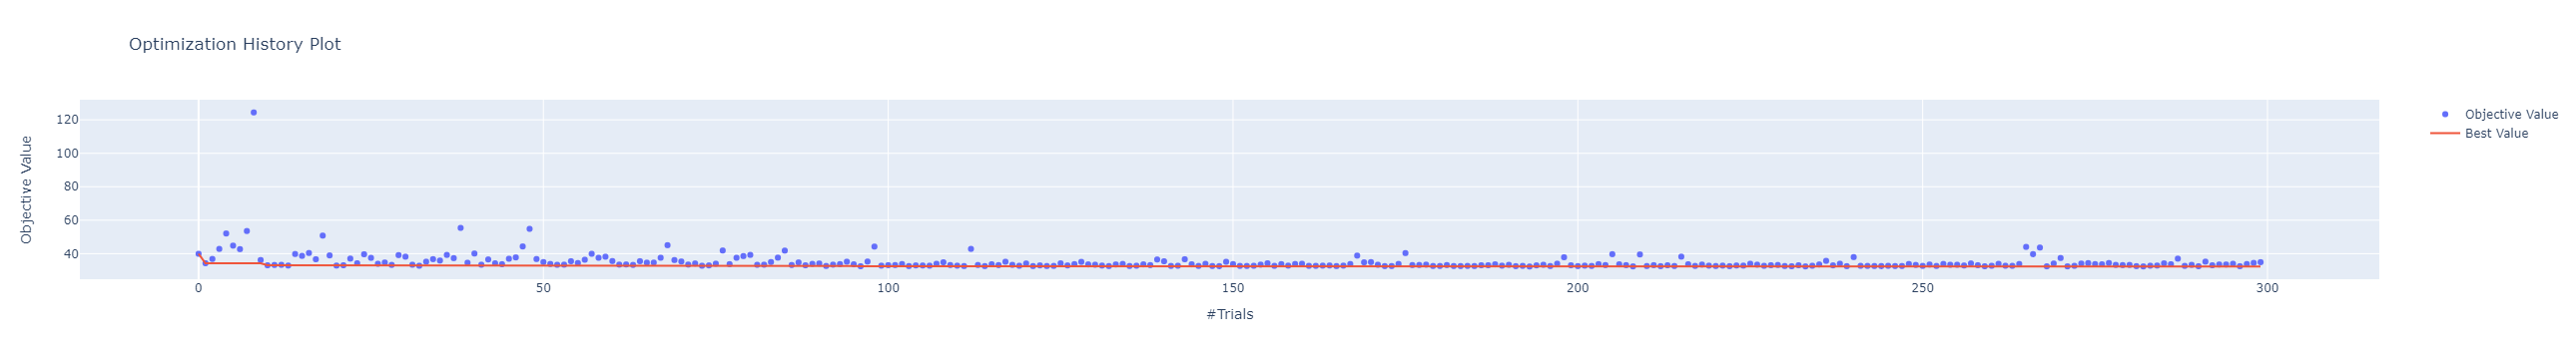

In [203]:
optuna.visualization.plot_optimization_history(study)

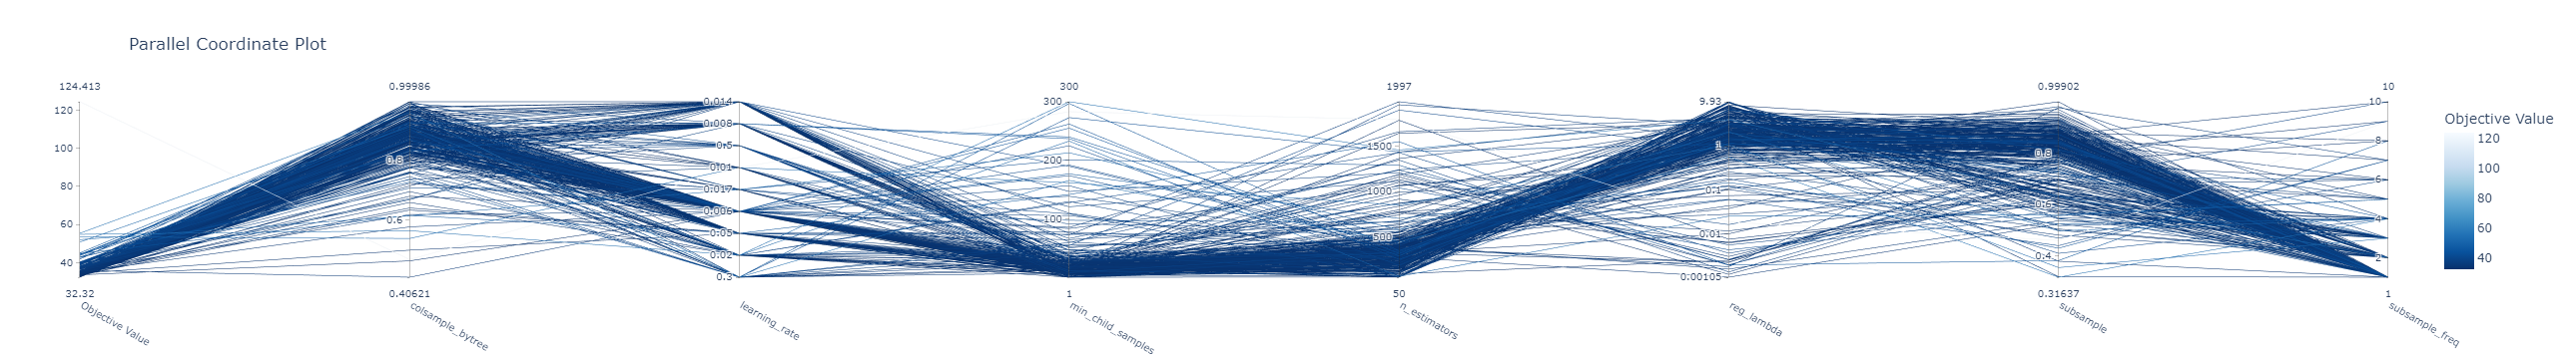

In [204]:
optuna.visualization.plot_parallel_coordinate(study)

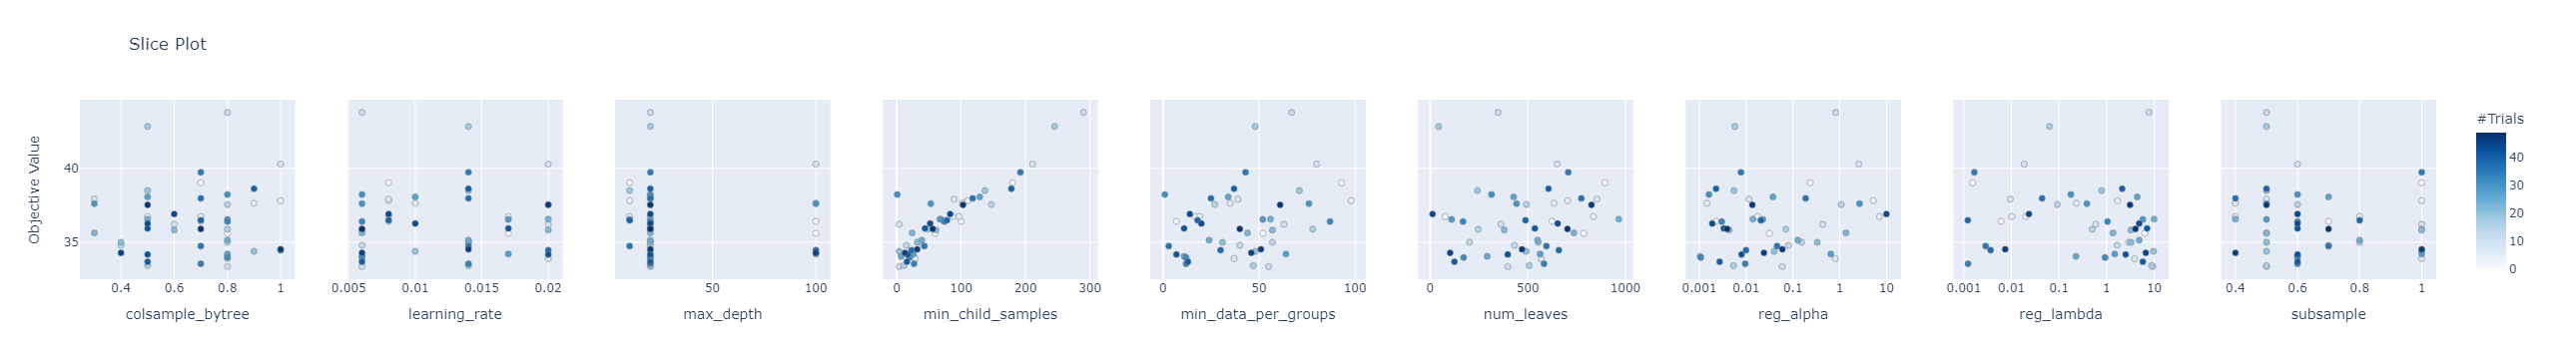

In [164]:
optuna.visualization.plot_slice(study)

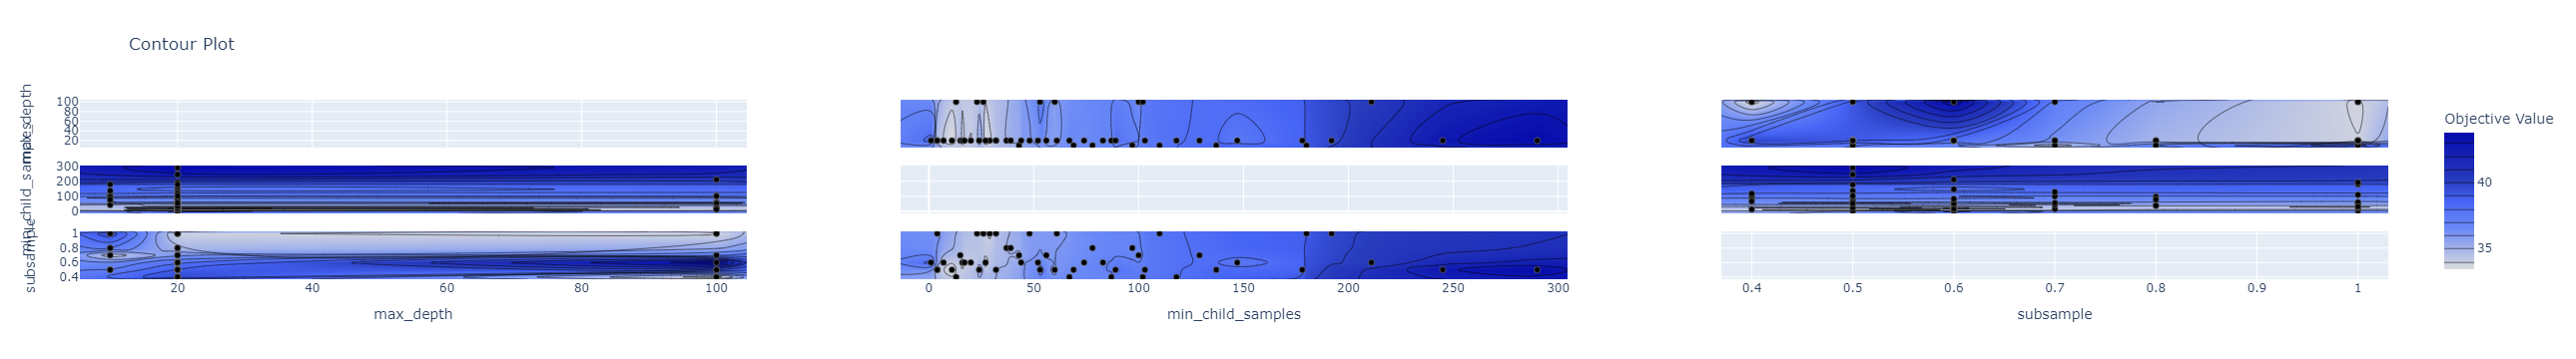

In [165]:
optuna.visualization.plot_contour(
    study,
    params=[
        "max_depth",
#         "num_leaves",
#         "colsample_bytree",
        "subsample",
#         "subsample_freq",
        "min_child_samples",
#         "max_bin",
    ],
)

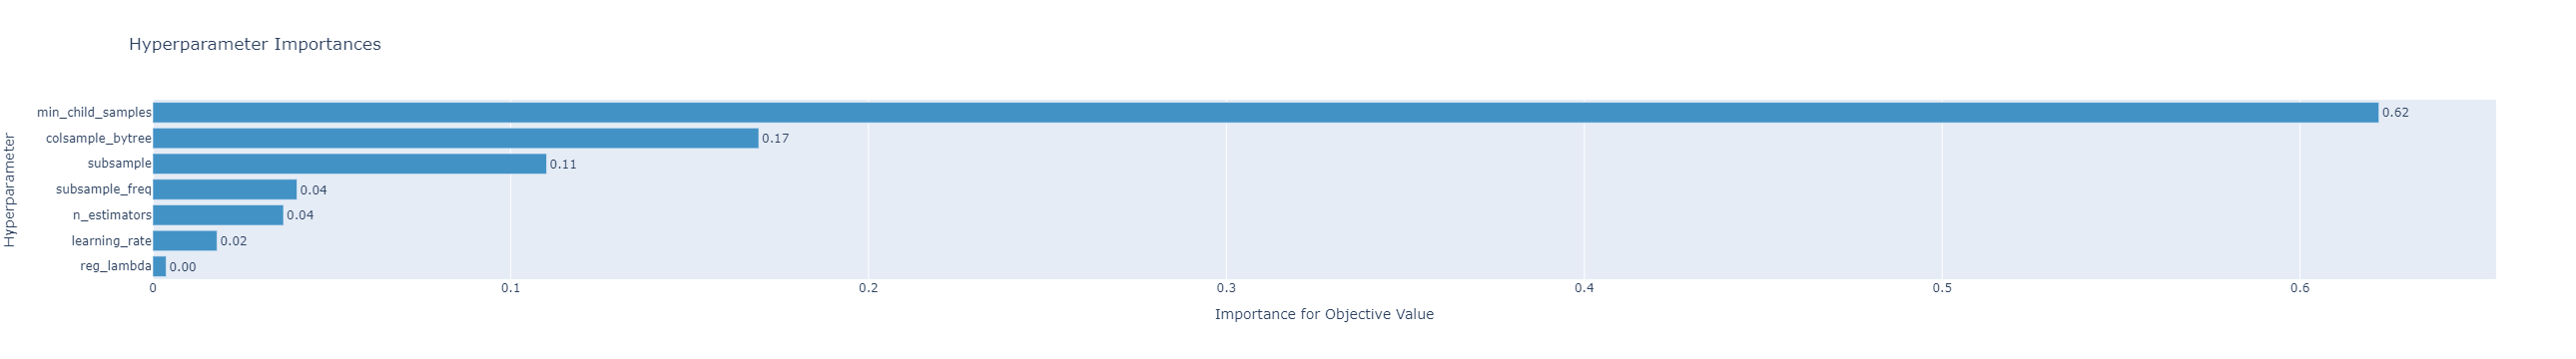

In [205]:
optuna.visualization.plot_param_importances(study)

In [206]:
params = study.best_params
params['random_state'] = 48
params['metric'] = 'rmse'
params

{'subsample_freq': 1,
 'n_estimators': 400,
 'reg_lambda': 1.098483059731807,
 'colsample_bytree': 0.8926265608852756,
 'subsample': 0.7835769545794111,
 'learning_rate': 0.006,
 'min_child_samples': 9,
 'random_state': 48,
 'metric': 'rmse'}

In [207]:
model = LGBMRegressor(**params)

In [208]:
model.fit(X, y)

LGBMRegressor(colsample_bytree=0.8926265608852756, learning_rate=0.006,
              metric='rmse', min_child_samples=9, n_estimators=400,
              random_state=48, reg_lambda=1.098483059731807,
              subsample=0.7835769545794111, subsample_freq=1)

In [210]:
x_test = scaler.transform(test_data)
x_test

array([[-1.37867647e-03,  3.04347826e-01,  6.54275093e-01, ...,
         3.11475410e-01,  1.34615385e-01,  2.31707317e-01],
       [-9.19117647e-04,  7.39130435e-01,  1.00000000e+00, ...,
         4.75409836e-01,  1.53846154e-01,  3.41463415e-01],
       [-4.59558824e-04,  5.65217391e-01,  5.91078067e-01, ...,
         1.39344262e-01,  1.03846154e-01,  2.43902439e-01],
       ...,
       [ 9.93566176e-01,  3.91304348e-01,  7.50929368e-01, ...,
         1.39344262e-01,  3.07692308e-02,  8.53658537e-02],
       [ 9.94025735e-01,  6.95652174e-01,  8.88475836e-01, ...,
         2.37704918e-01,  1.19230769e-01,  2.19512195e-01],
       [ 9.99080882e-01,  3.47826087e-01,  7.13754647e-01, ...,
         3.27868852e-02,  8.07692308e-02,  1.95121951e-01]])

In [211]:
res = model.predict(x_test)

In [212]:
submission['count'] = res
submission.to_csv('./optuna_lgbm1.csv', index=False)